In [2]:
import pandas as pd

naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_transbench101_micro'

In [3]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores

search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [41]:
dfs.keys()

dict_keys(['class_scene', 'class_object', 'autoencoder', 'normal', 'jigsaw', 'room_layout', 'segmentsemantic', 'ninapro', 'svhn', 'scifar100'])

In [320]:
dataset = 'normal'
data = dfs[dataset]

In [321]:
import json
with open('meta.json', 'r') as f:
    meta = json.load(f)
nb201_unique = [v['nb201-string'] for k, v in meta['ids'].items() if k == v['isomorph']]
nb201_unique[0]

'|avg_pool_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|skip_connect~2|'

In [322]:
print(len(data))

4096


In [323]:
from zc_combine.features.conversions import keep_only_isomorpic_nb201

data = keep_only_isomorpic_nb201(data, meta, zero_is_1=False)

In [324]:
from zc_combine.fixes.operations import get_ops_edges_tnb101
from zc_combine.fixes.utils import nb201_zero_out_unreachable

_, edge_map = get_ops_edges_tnb101()
nb201_zero_out_unreachable(data, edge_map, zero_op=0)

In [325]:
print(len(data))
data = data[data['net'] == data['new_net']]
print(len(data))

1219
1079


In [326]:
from zc_combine.features.conversions import tnb101_to_graph

nets = {i: tnb101_to_graph(data.loc[i]) for i in data.index}

In [327]:
import json

with open('../zc_combine/configs/tnb101_first.json', 'r') as f:
    cfg = json.load(f)

In [328]:
from zc_combine.features.nasbench201 import feature_func_dict
from zc_combine.features.dataset import get_feature_dataset

feature_dataset = get_feature_dataset(nets, cfg, feature_func_dict)
feature_dataset.keys()

dict_keys(['op_count', 'op_on_position', 'min_path_len', 'max_op_on_path', 'node_degree'])

In [329]:
features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
dataset = pd.concat([feature_dataset[f] for f in features], axis=1)
dataset['val_accs'] = data['val_accs']
dataset

,op_count_0,op_count_1,op_count_2,op_count_3,op_count_4,min_path_len_banned_[0],"min_path_len_banned_[0, 1]",max_op_on_path_allowed_[1],"max_op_on_path_allowed_[1, 2]","max_op_on_path_allowed_[1, 2, 3]",...,"node_degree_allowed_[1, 2]_avg_out","node_degree_allowed_[1, 3]_in_degree","node_degree_allowed_[1, 3]_out_degree","node_degree_allowed_[1, 3]_avg_in","node_degree_allowed_[1, 3]_avg_out","node_degree_allowed_[1, 2, 3]_in_degree","node_degree_allowed_[1, 2, 3]_out_degree","node_degree_allowed_[1, 2, 3]_avg_in","node_degree_allowed_[1, 2, 3]_avg_out",val_accs
idx,,,,,,,,,,,,,,,,,,,,,
0,0,0,3,3,0,1,1,0,4,6,...,0.75,2,2,0.75,0.75,3,3,1.50,1.50,0.570092
1,0,3,2,1,0,1,1,2,4,6,...,1.25,2,1,1.00,1.00,3,3,1.50,1.50,0.548806
6,0,2,2,2,0,1,1,2,4,6,...,1.00,2,2,1.00,1.00,3,3,1.50,1.50,0.555996
7,0,1,2,3,0,1,1,2,2,6,...,0.75,3,2,1.00,1.00,3,3,1.50,1.50,0.557633
8,0,2,2,2,0,1,1,4,6,6,...,1.00,2,2,1.00,1.00,3,3,1.50,1.50,0.551597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4082,1,0,2,3,0,2,2,0,4,6,...,0.50,1,1,0.75,0.75,2,2,1.25,1.25,0.545252
4086,1,2,2,1,0,2,2,4,4,6,...,1.00,2,1,0.75,0.75,2,2,1.25,1.25,0.554570
4087,1,0,1,4,0,1,1,0,2,4,...,0.25,2,3,1.00,1.00,3,3,1.25,1.25,0.549676


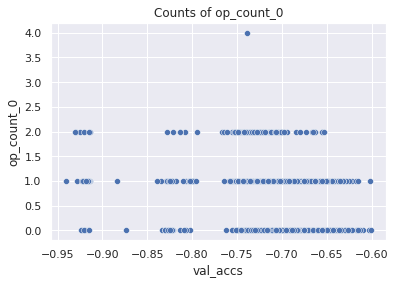

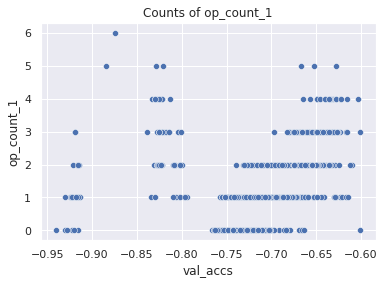

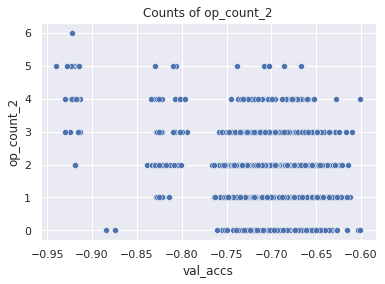

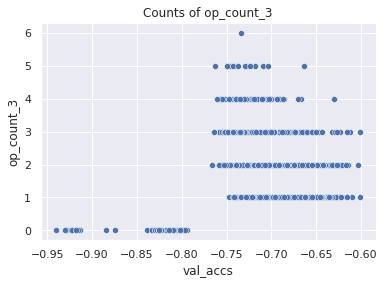

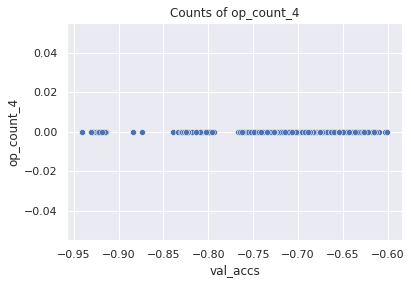

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plot_df = feature_dataset['op_count'].copy()
plot_df['val_accs'] = data['val_accs']

import os
#os.mkdir('tmp')

for c in plot_df.columns:
    if c == 'val_accs':
        continue
    plt.figure()
    sns.scatterplot(data=plot_df, x='val_accs', y=c)
    plt.title(f"Counts of {c}")
    #plt.savefig(f'tmp/{c}.png')
    plt.show()

In [277]:
edges = list(edge_map.keys())

dataset_raw = {i: [n[1][e] for e in edges] for i, n in nets.items()}
dataset_raw[0]

[2, 3, 2, 3, 2, 3]

In [278]:
draw = [{'idx': i, **{f'op_{j}': v for j, v in enumerate(o)}} for i, o in dataset_raw.items()]
draw = pd.DataFrame(draw).set_index('idx')

In [330]:
proxy_cols = [c for c in data.columns if c not in ['random', 'rank', 'new_net', 'net']]


def get_dataset(feature_dfs, proxy_df, features, cols):
    feat_dfs = [feature_dfs[f] for f in features]
    prox_df = proxy_df[cols]

    res_data = pd.concat([*feat_dfs, prox_df], axis=1)

    y = proxy_df['val_accs'].loc[res_data.index]
    if 'val_accs' in res_data:
        res_data.drop(columns=['val_accs'], inplace=True)

    return res_data, y

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
full_data, full_y = get_dataset(feature_dataset, data, features, ['flops', 'params'])
print(full_data.shape)
full_data

(1079, 48)


,op_count_0,op_count_1,op_count_2,op_count_3,op_count_4,min_path_len_banned_[0],"min_path_len_banned_[0, 1]",max_op_on_path_allowed_[1],"max_op_on_path_allowed_[1, 2]","max_op_on_path_allowed_[1, 2, 3]",...,"node_degree_allowed_[1, 3]_in_degree","node_degree_allowed_[1, 3]_out_degree","node_degree_allowed_[1, 3]_avg_in","node_degree_allowed_[1, 3]_avg_out","node_degree_allowed_[1, 2, 3]_in_degree","node_degree_allowed_[1, 2, 3]_out_degree","node_degree_allowed_[1, 2, 3]_avg_in","node_degree_allowed_[1, 2, 3]_avg_out",flops,params
0,0,0,3,3,0,1,1,0,4,6,...,2,2,0.75,0.75,3,3,1.50,1.50,6285.262848,45.212499
1,0,3,2,1,0,1,1,2,4,6,...,2,1,1.00,1.00,3,3,1.50,1.50,3342.270464,30.731859
6,0,2,2,2,0,1,1,2,4,6,...,2,2,1.00,1.00,3,3,1.50,1.50,4854.775808,38.404691
7,0,1,2,3,0,1,1,2,2,6,...,3,2,1.00,1.00,3,3,1.50,1.50,6165.954560,44.701267
8,0,2,2,2,0,1,1,4,6,6,...,2,2,1.00,1.00,3,3,1.50,1.50,4854.775808,38.404691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4082,1,0,2,3,0,2,2,0,4,6,...,1,1,0.75,0.75,2,2,1.25,1.25,6341.197824,45.903699
4086,1,2,2,1,0,2,2,4,4,6,...,2,1,0.75,0.75,2,2,1.25,1.25,3367.206912,30.903891
4087,1,0,1,4,0,1,1,0,2,4,...,2,3,1.00,1.00,3,3,1.25,1.25,7457.112064,51.171155
4092,1,0,3,2,0,2,2,0,4,6,...,0,2,0.50,0.50,2,2,1.25,1.25,5200.347136,40.464211


In [331]:
import numpy as np
from scipy.stats import kendalltau, spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


def get_splits(fd, fy, train_size=100, seed=42):
    return train_test_split(fd, fy, random_state=seed, train_size=train_size)

def eval_rf(trx, tex, tryy, tey, n_times=1, random_state=43):
    res = {'score': [], 'tau': [], 'corr': []}
    rfs = []
    for i in range(n_times):
        rf = RandomForestRegressor(random_state=random_state + i, n_estimators=100)
        rf.fit(trx, tryy)
        res['score'].append(rf.score(tex, tey))

        preds = rf.predict(tex)
        res['tau'].append(kendalltau(preds, tey)[0])
        res['corr'].append(spearmanr(preds, tey)[0])
        rfs.append(rf)

    return rfs, res

def print_means(res):
    print(", ".join([f"{k}: {np.mean(v)}" for k, v in res.items()]))

In [55]:
import numpy as np

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
seed = 44
for ts in [100, 200, 1000]:
    print(f"Train size {ts}")
    for prox in proxy_cols:
        for include_fp in [True, False]:
            if prox in ['flops', 'params']:
                continue
            print(prox, "" if include_fp else " no fp")

            plist = ['flops', 'params', prox] if include_fp else [prox]
            fd, fy = get_dataset(feature_dataset, data, features, plist)
            data_splits = get_splits(fd, fy, train_size=ts, seed=seed)

            _, res = eval_rf(*data_splits, n_times=5)
            print_means(res)
            print()

Train size 100
val_accs 
score: 0.6787423763115997, tau: 0.5740546074273138, corr: 0.780726041345326

val_accs  no fp
score: 0.6748872078828627, tau: 0.5719029017302864, corr: 0.7788096798205985

fisher 
score: 0.6085873639028601, tau: 0.5447267197436796, corr: 0.7516003824988658

fisher  no fp
score: 0.6109488727812458, tau: 0.5465491100769831, corr: 0.7537425409847567

grad_norm 
score: 0.6514339788642677, tau: 0.566119931433341, corr: 0.7734745861608967

grad_norm  no fp
score: 0.6457422485036748, tau: 0.5643749495956852, corr: 0.7718653281554237

grasp 
score: 0.6620787974846533, tau: 0.564840602379714, corr: 0.772138884023787

grasp  no fp
score: 0.6590711838619836, tau: 0.563109589735769, corr: 0.7704565542916202

jacov 
score: 0.6892842161912963, tau: 0.570389176803156, corr: 0.7771262414258979

jacov  no fp
score: 0.6858659879669953, tau: 0.5694480238224684, corr: 0.7757712788486726

l2_norm 
score: 0.6852368435664417, tau: 0.5743438914627287, corr: 0.7814443232038176

l2_norm 

KeyboardInterrupt: 

In [349]:
ts = 100
seed = 43

all_proxies = False
prox_to_include = []
#prox_to_include = ['nwot']
with_features = True

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
feat_list = features if with_features else []

# proxies to add to data
def_proxlist = ['params', 'flops'] if prox_to_include is None else ['params', 'flops', *prox_to_include]
prox_list = proxy_cols if all_proxies else def_proxlist

fd, fy = get_dataset(feature_dataset, data, feat_list, prox_list)
train_X, test_X, train_y, test_y = get_splits(fd, fy, train_size=ts, seed=seed)

rfs, res = eval_rf(train_X, test_X, train_y, test_y, n_times=5)
print_means(res)
rf_fitted = rfs[0]
preds = rf_fitted.predict(fd)
preds

score: 0.7515244614128489, tau: 0.5044296759779479, corr: 0.6863546127408838


array([0.55818835, 0.54587222, 0.54926786, ..., 0.55532171, 0.54436524,
       0.54573029])

In [350]:
trainpreds = rf_fitted.predict(train_X)

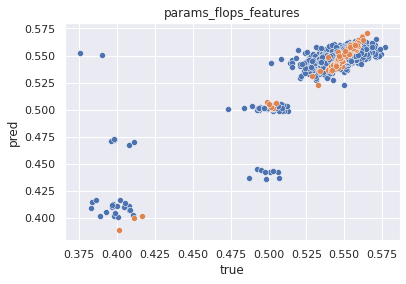

In [352]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=pd.DataFrame({'pred': preds, 'true': fy}), x='true', y='pred')
sns.scatterplot(data=pd.DataFrame({'pred': trainpreds, 'true': train_y}), x='pred', y='true')
#plt.ylim(70, 95)

plt_name = f"{'all_proxies' if all_proxies else 'params_flops'}_{'features' if with_features else 'no_features'}"
plt.title(plt_name)

#plt.xlim(50, 55)
#plt.ylim(50, 55)

#plt.savefig(f"tmp/{plt_name}.png")
plt.show()

In [69]:
imps = rf_fitted.feature_importances_

pd.DataFrame({"importance": imps, "feat": fd.columns})

,importance,feat
0,0.000855,op_count_0
1,0.020461,op_count_1
2,0.026268,op_count_2
3,0.002711,op_count_3
4,0.000000,op_count_4
5,0.101609,min_path_len_banned_[0]
6,0.092226,"min_path_len_banned_[0, 1]"
7,0.013687,max_op_on_path_allowed_[1]
8,0.004016,"max_op_on_path_allowed_[1, 2]"
9,0.002886,"max_op_on_path_allowed_[1, 2, 3]"


In [353]:
from sklearn.decomposition import PCA

pca_data = fd#data[proxy_cols]
pca = PCA(n_components=2)
pca_data = pca.fit_transform(pca_data)
pca_data

array([[ 1.47148744e+03, -2.99099786e+00],
       [-1.47154452e+03,  1.82622915e+00],
       [ 4.09814464e+01, -6.76953963e-02],
       ...,
       [ 2.64335405e+03, -6.20088552e-01],
       [ 3.86558713e+02, -4.05205586e+00],
       [-1.47268861e+03, -1.16623840e+00]])

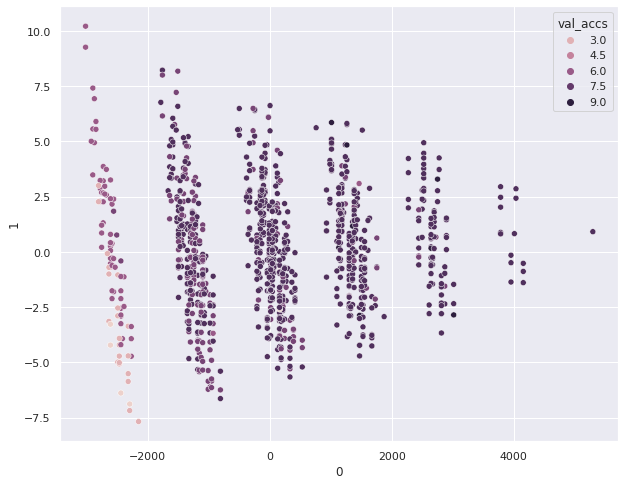

In [361]:
val_accss = data['val_accs'].to_numpy()
plot_dd = pd.DataFrame(pca_data)
plot_dd['val_accs'] = (val_accss - 0.3) * 100 // 3

plt.figure(figsize=(10,8))
sns.scatterplot(data=plot_dd, x=0, y=1, hue='val_accs')
#plt.xlim(-2000, 5000)
plt.show()

In [ ]:
# IDEA ... sample different nets based on clustering (max distance between nets...)

In [27]:
pd.DataFrame({'pred': preds, 'true': y, 'net': data['net']})

,pred,true,net
0,33.802667,32.700000,"(4, 0, 3, 1, 4, 3)"
1,43.273667,44.233333,"(2, 4, 0, 0, 3, 2)"
3,43.515333,40.600000,"(0, 0, 2, 1, 2, 3)"
7,37.090333,37.100000,"(4, 1, 3, 3, 3, 3)"
8,43.614667,42.200000,"(3, 1, 2, 3, 2, 3)"
...,...,...,...
15617,40.057667,40.400000,"(2, 1, 4, 2, 3, 0)"
15618,39.843000,39.300000,"(3, 2, 2, 4, 0, 0)"
15620,35.865667,36.433333,"(4, 2, 1, 4, 3, 0)"
15622,40.240333,44.066667,"(2, 3, 3, 3, 2, 4)"


In [28]:
from scipy.stats import kendalltau, spearmanr

kendalltau(preds, dsy)[0], spearmanr(preds, dsy)[0]

(0.6811114913133042, 0.8547273907942495)

In [757]:
# TODO ruzny pocty siti
# where to sample... important
# TODO predikovat pres proxyny

# TODO vyplot predikci jen pres flops/params
# ... try that on transnb101

In [ ]:
#Next steps:

# TODO lepsi nazvy sloupecku, to str
# TODO fce co to spocita a da do df (myslim ty edge_path_op atd)
# TODO predikce - pres ruzny seedy, mozna crossval
# TODO porovnani s proxynama a bez, xgboost,...
# TODO tnb101

# TODO ruzny dalsi features...